In [1]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os

#Font size for the plots
plt.rcParams['font.size'] = '16'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

export_dir = '/home/pgonzalez/Dropbox/quant_datasetshift/'
quantificators = ["CC", "ACC", "PCC", "PACC", "HDy", "DyS", "SMM", "SLD","MLPE"]
error = "MAE"
dateexperiment = "2022_09_26_17_55"

results_dict={}
print("Loading results... ",sep="")
for quant_name in quantificators:
    results_dict[quant_name] = pd.read_csv("results/prior/results_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results_dict[quant_name]['p_train'] = results_dict[quant_name]['p_train'].round(2)
    results_dict[quant_name]['p_test'] = results_dict[quant_name]['p_test'].round(2)
    results_dict[quant_name]['prior_measure'] = results_dict[quant_name]['p_test']-results_dict[quant_name]['p_train']
    results_dict[quant_name]['prior_measure'] = results_dict[quant_name]['prior_measure'].round(1)
print("Done")

mean_error_methods = {}

writer = pd.ExcelWriter('results/prior/excel/errors_%s.xlsx' % dateexperiment, engine='xlsxwriter')
for quant_name in quantificators:
    results = results_dict[quant_name]
    results_mean = results.groupby(['p_train', 'p_test'])['error'].mean().reset_index()
    #convert to matrix form
    results_mean = results_mean.pivot(index='p_train', columns='p_test', values='error')
    mean_error_methods[quant_name]=results_mean.mean().mean()
    results_mean.columns = results_mean.columns.map(lambda x: "%.2f" % float(x))
    print("Results for method %s. Mean %s: %f" % (quant_name,error, mean_error_methods[quant_name]))
    cm = sns.light_palette('red', as_cmap=True)
    display(results_mean.style.format_index('{:.2f}').format('{:.3f}').background_gradient(cmap=cm,low=0,high=1))

    results_mean.to_excel(writer, sheet_name=quant_name)
    workbook = writer.book
    worksheet = writer.sheets[quant_name]
    # Apply a conditional format to the cell range.
    worksheet.conditional_format('B2:L12', {'type': '2_color_scale','min_type':'num','max_type':'num','min_value':'0','max_value':'1','min_color':'#f3f0f0','max_color':'#ff0000'})
writer.close()

Loading results... 
Done
Results for method CC. Mean MAE: 0.144952


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.012,0.060,0.138,0.212,0.287,0.365,0.438,0.515,0.593,0.666,0.742
0.10,0.109,0.073,0.033,0.015,0.048,0.087,0.126,0.169,0.204,0.246,0.290
0.20,0.118,0.088,0.052,0.023,0.024,0.049,0.084,0.122,0.151,0.186,0.227
0.30,0.108,0.082,0.053,0.023,0.013,0.031,0.061,0.093,0.117,0.148,0.181
0.40,0.121,0.096,0.067,0.037,0.016,0.017,0.044,0.075,0.098,0.128,0.162
0.50,0.139,0.113,0.086,0.055,0.031,0.011,0.027,0.057,0.080,0.111,0.142
0.60,0.157,0.131,0.101,0.071,0.046,0.021,0.016,0.041,0.065,0.096,0.129
0.70,0.175,0.149,0.119,0.087,0.062,0.033,0.014,0.028,0.053,0.085,0.119
0.80,0.219,0.189,0.153,0.118,0.088,0.054,0.025,0.023,0.046,0.083,0.120


Results for method ACC. Mean MAE: 0.059646


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.037,0.142,0.216,0.317,0.362,0.363,0.324,0.260,0.181,0.098,0.020
0.10,0.015,0.027,0.033,0.042,0.051,0.057,0.066,0.070,0.071,0.055,0.005
0.20,0.010,0.019,0.021,0.026,0.028,0.032,0.037,0.040,0.044,0.045,0.006
0.30,0.009,0.017,0.019,0.021,0.024,0.027,0.029,0.030,0.034,0.035,0.003
0.40,0.008,0.019,0.018,0.018,0.019,0.019,0.022,0.021,0.024,0.024,0.008
0.50,0.006,0.020,0.017,0.019,0.018,0.016,0.020,0.019,0.021,0.020,0.007
0.60,0.003,0.027,0.027,0.026,0.023,0.018,0.020,0.020,0.020,0.018,0.012
0.70,0.005,0.026,0.025,0.024,0.023,0.019,0.021,0.020,0.019,0.017,0.012
0.80,0.002,0.039,0.038,0.037,0.032,0.028,0.027,0.027,0.022,0.020,0.021


Results for method PCC. Mean MAE: 0.155989


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.357,0.268,0.177,0.086,0.005,0.097,0.187,0.278,0.369,0.460,0.551
0.10,0.246,0.182,0.115,0.048,0.018,0.086,0.152,0.220,0.286,0.352,0.421
0.20,0.128,0.085,0.039,0.017,0.053,0.098,0.145,0.192,0.237,0.283,0.331
0.30,0.105,0.072,0.035,0.010,0.036,0.071,0.108,0.146,0.181,0.217,0.256
0.40,0.136,0.105,0.070,0.035,0.010,0.031,0.066,0.102,0.134,0.169,0.207
0.50,0.169,0.139,0.105,0.070,0.038,0.011,0.030,0.065,0.097,0.132,0.168
0.60,0.209,0.177,0.141,0.105,0.073,0.041,0.011,0.032,0.065,0.101,0.138
0.70,0.261,0.228,0.190,0.153,0.118,0.082,0.045,0.012,0.028,0.067,0.106
0.80,0.331,0.287,0.238,0.188,0.143,0.096,0.048,0.008,0.049,0.097,0.147


Results for method PACC. Mean MAE: 0.032121


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.002,0.056,0.053,0.049,0.052,0.060,0.074,0.088,0.100,0.078,0.002
0.10,0.001,0.029,0.024,0.023,0.028,0.037,0.047,0.057,0.069,0.073,0.000
0.20,0.003,0.018,0.018,0.021,0.026,0.031,0.037,0.043,0.049,0.056,0.002
0.30,0.005,0.018,0.018,0.019,0.021,0.025,0.028,0.031,0.036,0.041,0.001
0.40,0.004,0.018,0.016,0.016,0.016,0.017,0.021,0.021,0.025,0.027,0.003
0.50,0.003,0.019,0.016,0.016,0.016,0.016,0.018,0.018,0.021,0.021,0.004
0.60,0.002,0.026,0.024,0.022,0.018,0.015,0.016,0.017,0.017,0.018,0.004
0.70,0.001,0.030,0.028,0.024,0.021,0.016,0.017,0.017,0.017,0.018,0.006
0.80,0.002,0.047,0.045,0.042,0.033,0.025,0.021,0.020,0.017,0.018,0.006


Results for method HDy. Mean MAE: 0.026087


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.008,0.028,0.037,0.047,0.053,0.062,0.065,0.072,0.072,0.066,0.049
0.10,0.003,0.020,0.024,0.025,0.028,0.027,0.028,0.032,0.033,0.033,0.026
0.20,0.002,0.022,0.026,0.026,0.029,0.027,0.029,0.031,0.029,0.029,0.019
0.30,0.002,0.017,0.018,0.017,0.019,0.016,0.016,0.019,0.017,0.016,0.012
0.40,0.003,0.017,0.017,0.017,0.017,0.015,0.017,0.017,0.016,0.015,0.007
0.50,0.007,0.016,0.016,0.016,0.018,0.015,0.017,0.018,0.016,0.016,0.009
0.60,0.006,0.017,0.019,0.020,0.019,0.019,0.019,0.019,0.018,0.016,0.006
0.70,0.006,0.017,0.018,0.019,0.022,0.020,0.021,0.021,0.022,0.019,0.006
0.80,0.008,0.022,0.025,0.025,0.027,0.025,0.024,0.025,0.022,0.019,0.010


Results for method DyS. Mean MAE: 0.026866


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.011,0.030,0.041,0.058,0.072,0.085,0.097,0.111,0.114,0.104,0.076
0.10,0.005,0.016,0.018,0.021,0.024,0.027,0.028,0.031,0.033,0.033,0.019
0.20,0.003,0.018,0.019,0.021,0.023,0.023,0.022,0.025,0.022,0.021,0.014
0.30,0.004,0.013,0.014,0.015,0.016,0.016,0.017,0.019,0.020,0.018,0.007
0.40,0.006,0.014,0.014,0.016,0.016,0.015,0.016,0.015,0.016,0.014,0.007
0.50,0.006,0.015,0.015,0.017,0.017,0.016,0.018,0.018,0.017,0.015,0.009
0.60,0.005,0.018,0.018,0.018,0.017,0.016,0.018,0.018,0.017,0.017,0.008
0.70,0.013,0.022,0.021,0.020,0.021,0.019,0.019,0.016,0.016,0.014,0.007
0.80,0.008,0.022,0.022,0.022,0.021,0.021,0.021,0.020,0.019,0.017,0.006


Results for method SMM. Mean MAE: 0.030105


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.011,0.033,0.039,0.047,0.057,0.062,0.072,0.081,0.081,0.072,0.044
0.10,0.006,0.016,0.018,0.021,0.025,0.030,0.033,0.038,0.040,0.044,0.013
0.20,0.006,0.018,0.019,0.021,0.023,0.025,0.027,0.031,0.031,0.033,0.015
0.30,0.007,0.019,0.018,0.019,0.019,0.020,0.021,0.024,0.023,0.025,0.011
0.40,0.007,0.016,0.016,0.016,0.017,0.017,0.020,0.020,0.022,0.022,0.011
0.50,0.008,0.019,0.018,0.019,0.019,0.019,0.020,0.021,0.021,0.021,0.011
0.60,0.006,0.021,0.019,0.018,0.018,0.015,0.017,0.017,0.017,0.016,0.007
0.70,0.005,0.026,0.024,0.023,0.022,0.018,0.017,0.018,0.017,0.016,0.007
0.80,0.016,0.029,0.027,0.025,0.025,0.020,0.019,0.020,0.019,0.018,0.011


Results for method SLD. Mean MAE: 0.022323


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.010,0.032,0.037,0.043,0.054,0.053,0.056,0.056,0.056,0.045,0.016
0.10,0.002,0.015,0.018,0.021,0.026,0.026,0.028,0.027,0.026,0.022,0.012
0.20,0.002,0.013,0.015,0.017,0.021,0.021,0.022,0.023,0.021,0.019,0.010
0.30,0.002,0.013,0.014,0.015,0.017,0.017,0.018,0.018,0.017,0.015,0.008
0.40,0.001,0.013,0.014,0.014,0.015,0.014,0.017,0.017,0.016,0.014,0.007
0.50,0.001,0.015,0.015,0.014,0.015,0.015,0.017,0.017,0.017,0.015,0.007
0.60,0.001,0.016,0.018,0.016,0.015,0.013,0.015,0.015,0.015,0.013,0.006
0.70,0.001,0.016,0.018,0.017,0.016,0.014,0.016,0.015,0.015,0.013,0.007
0.80,0.001,0.020,0.023,0.022,0.019,0.017,0.016,0.017,0.015,0.013,0.007


Results for method MLPE. Mean MAE: 0.360998


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.02,0.020,0.078,0.178,0.278,0.379,0.480,0.580,0.680,0.780,0.880,0.980
0.10,0.100,0.002,0.099,0.199,0.299,0.400,0.500,0.600,0.700,0.800,0.900
0.20,0.200,0.102,0.001,0.099,0.199,0.300,0.400,0.500,0.600,0.700,0.800
0.30,0.300,0.202,0.101,0.001,0.099,0.200,0.300,0.400,0.500,0.600,0.700
0.40,0.400,0.302,0.201,0.101,0.001,0.100,0.200,0.300,0.400,0.500,0.600
0.50,0.500,0.402,0.302,0.202,0.101,0.000,0.100,0.200,0.300,0.400,0.500
0.60,0.600,0.502,0.402,0.302,0.201,0.100,0.000,0.100,0.200,0.300,0.400
0.70,0.700,0.602,0.502,0.402,0.301,0.200,0.100,0.000,0.100,0.200,0.300
0.80,0.800,0.702,0.602,0.502,0.401,0.300,0.200,0.100,0.000,0.100,0.200


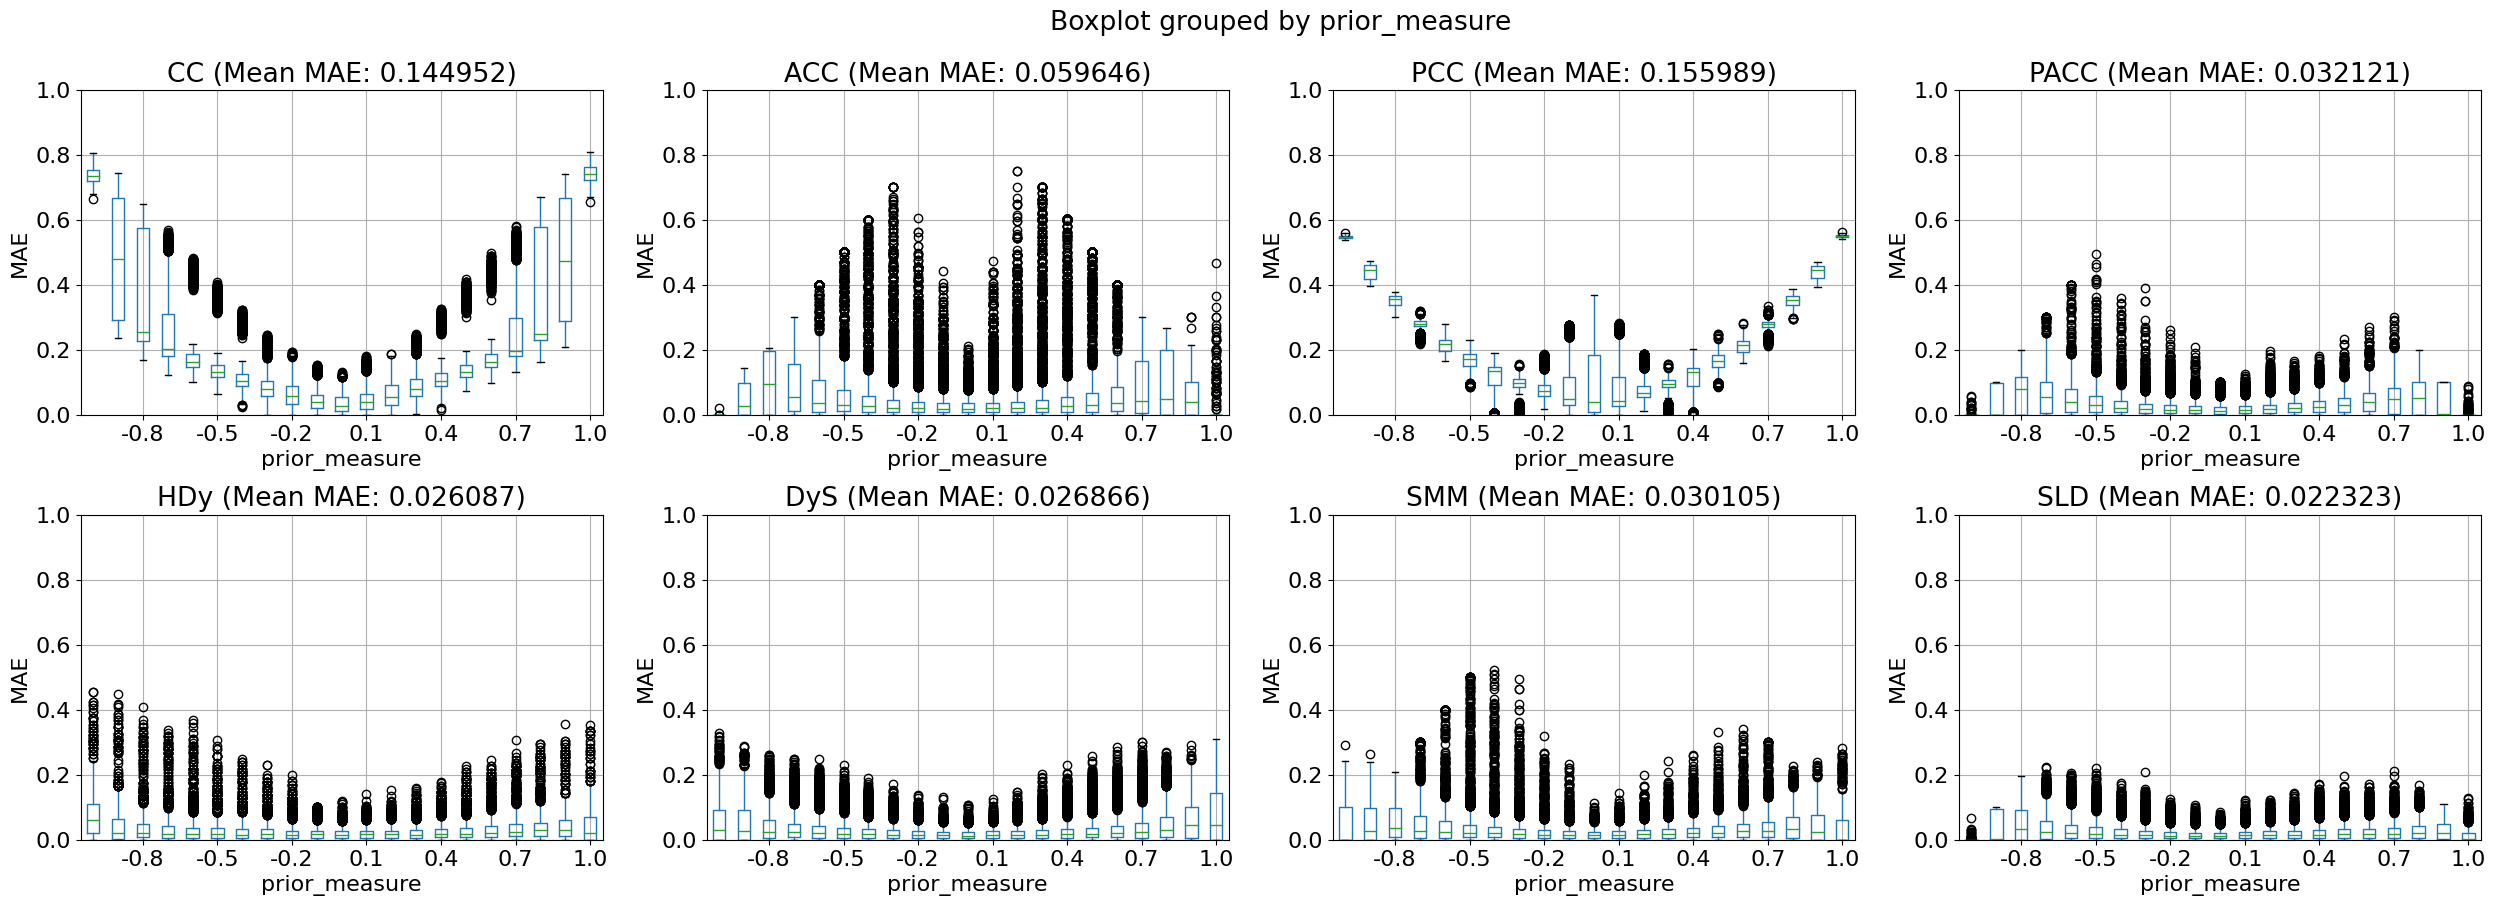

In [2]:
import matplotlib.ticker as ticker

quantificators = ["CC", "ACC", "PCC", "PACC", "HDy","DyS","SMM", "SLD"]
n_cols=4
fig, ax = plt.subplots(2,n_cols,figsize=(30,10))
pd.set_option('display.max_rows', 500)

for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    ax[k//n_cols][k%n_cols].set_ylim(0, 1)
    ax[k//n_cols][k%n_cols].set_ylabel(error)
    ax[k//n_cols][k%n_cols].tick_params(axis='x', rotation=90)
    fig.tight_layout()
    results.boxplot(ax=ax[k//n_cols][k%n_cols],column='error',by='prior_measure')
    ax[k//n_cols][k%n_cols].xaxis.set_major_locator(ticker.MultipleLocator(3))
    ax[k//n_cols][k%n_cols].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[quant_name]))

### Tables and charts to be included in a paper

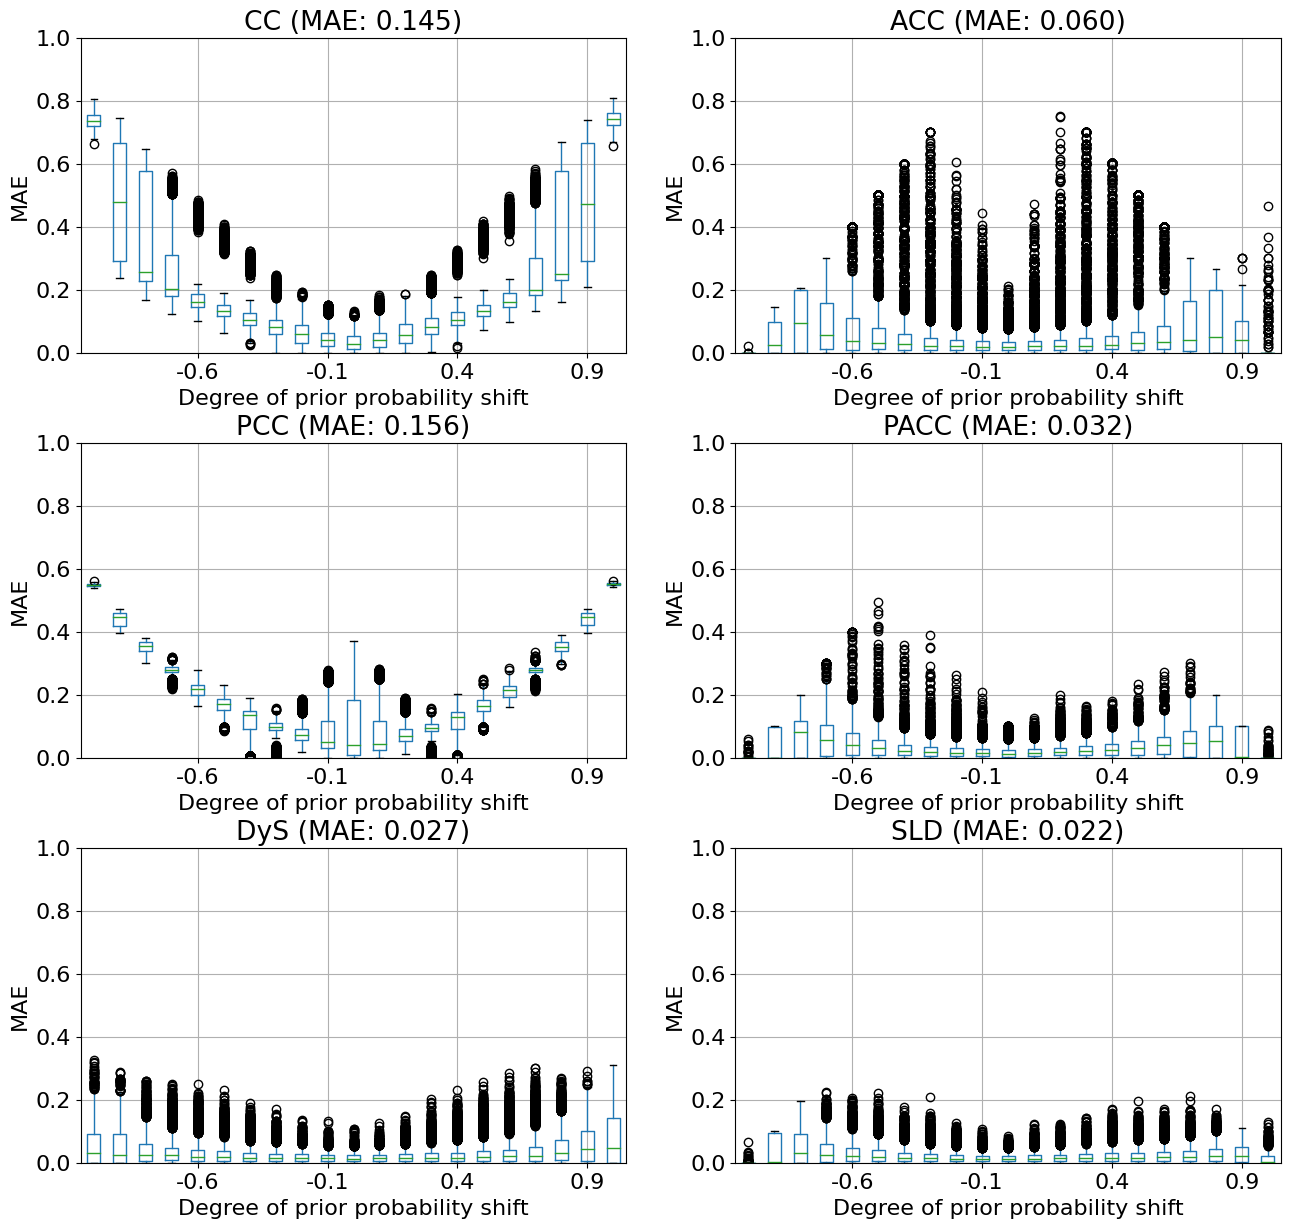

In [43]:
quantificators = ["CC", "ACC", "PCC", "PACC","DyS", "SLD"]
n_cols = 2
fig, ax = plt.subplots(3,n_cols,figsize=(15,15))
for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    ax[k//n_cols][k%n_cols].set_ylim(0, 1)
    
    ax[k//n_cols][k%n_cols].set_ylabel(error)
    ax[k//n_cols][k%n_cols].tick_params(axis='x', rotation=90)
    fig.tight_layout()
    results.boxplot(ax=ax[k//n_cols][k%n_cols],column='error',by='prior_measure')
    plt.suptitle('')
    ax[k//n_cols][k%n_cols].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[k//n_cols][k%n_cols].set_xlabel("Degree of prior probability shift")
    
    ax[k//n_cols][k%n_cols].set_title("%s (%s: %.3f)"  % (quant_name,error,mean_error_methods[quant_name]))
plt.savefig(os.path.join(export_dir,"images/priorresults.pdf"),format='pdf',bbox_inches='tight')
plt.savefig(os.path.join(export_dir,"images/priorresults.png"),format='png',bbox_inches='tight')

## Main table to put in the paper with results for prior probability shift

In [13]:
from utils.wilcoxon import wilcoxon_test
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "SLD"]
global_results = pd.DataFrame(columns = quantificators,index=np.linspace(-1,1,21).round(1),dtype=float)
for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    results = results.groupby(by='prior_measure')['error'].mean()
    global_results.loc[:, quant_name] = results

global_results_style = global_results.style.format('{:.3f}').format_index('{:.1f}')

#We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
for i,r in global_results.iterrows():
        #compute the best method for this experiment
        prior_measure = r.name
        best_method = r.index[r.argmin()]
        #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
        #Get data for the winner method
        results_best = results_dict[best_method].loc[(results_dict[best_method]['prior_measure']==prior_measure),'error'].to_numpy()
        #We need to get all the rows in results that matches this experiment for each method
        for quant_name in quantificators:
            if quant_name!=best_method:
                #print("Comparing %s with %s" % (best_method,quant_name))
                results_method = results_dict[quant_name].loc[results_dict[quant_name]['prior_measure']==prior_measure,'error'].to_numpy()
                global_results_style.set_properties(subset=(prior_measure, quant_name),**wilcoxon_test(results_best,results_method))


result = global_results_style.highlight_min(axis=1,props='textbf:--rwrap;')
display(result)
columns = 'r'*len(quantificators)
with open(os.path.join(export_dir,'tables/prior_table.tex'), 'w') as f:
    f.write(result.to_latex(hrules=True,column_format="r|"+columns).replace(' 0.',' .').replace('{0.','{.'))



,CC,ACC,PCC,PACC,DyS,SLD
-1.0,0.737,0.000,0.548,0.001,0.063,0.001
-0.9,0.479,0.049,0.439,0.044,0.053,0.041
-0.8,0.355,0.088,0.352,0.077,0.045,0.049
-0.7,0.271,0.099,0.278,0.069,0.040,0.041
-0.6,0.213,0.094,0.216,0.054,0.032,0.034
-0.5,0.166,0.086,0.162,0.042,0.028,0.029
-0.4,0.126,0.071,0.115,0.031,0.024,0.023
-0.3,0.091,0.055,0.093,0.025,0.021,0.020
-0.2,0.064,0.041,0.085,0.023,0.019,0.017
-0.1,0.047,0.032,0.091,0.022,0.017,0.015


## Main table to put in the paper with results for prior probability shift (Transposed)

In [11]:
from utils.wilcoxon import wilcoxon_test

global_results_t = global_results.T
global_results_t.columns = global_results_t.columns.map(lambda x: "%.1f" % x)
print(global_results_t)
global_results_style_t = global_results_t.style.format('{:.3f}')
#We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
for c in global_results_t:
        #compute the best method for this experiment
        prior_measure = c
        best_method = global_results_t[c].index[global_results_t[c].argmin()]
        
        #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
        #Get data for the winner method
        results_best = results_dict[best_method].loc[results_dict[best_method]['prior_measure']==float(prior_measure),'error'].to_numpy()
        #We need to get all the rows in results that matches this experiment for each method
        for quant_name in quantificators:
            if quant_name!=best_method:
                #print("Comparing %s with %s" % (best_method,quant_name))
                results_method = results_dict[quant_name].loc[results_dict[quant_name]['prior_measure']==float(prior_measure),'error'].to_numpy()
                global_results_style_t.set_properties(subset=(quant_name, prior_measure),**wilcoxon_test(results_best,results_method))


result = global_results_style_t.highlight_min(axis=0,props='textbf:--rwrap;')
display(result)
columns = 'r'*21
with open(os.path.join(export_dir,'tables/prior_table_t.tex'), 'w') as f:
    latex_code = result.to_latex(hrules=True,column_format="l|"+columns)
    splits = latex_code.split('\midrule')
    latex_code = splits[0]+'\midrule'+splits[1].replace(' 0.',' .').replace('{0.','{.')
    print(latex_code)
    f.write(latex_code)

          -1.0      -0.9      -0.8      -0.7      -0.6      -0.5      -0.4      -0.3      -0.2      -0.1       0.0       0.1       0.2       0.3  \
CC    0.737212  0.479282  0.354964  0.271420  0.212535  0.165565  0.125648  0.090804  0.063566  0.046662  0.035279  0.047942  0.064229  0.092456   
ACC   0.000040  0.048508  0.087528  0.099442  0.093698  0.085942  0.070823  0.055273  0.041151  0.032000  0.026053  0.034480  0.045738  0.062760   
PCC   0.548326  0.439000  0.351635  0.278396  0.216365  0.162208  0.114694  0.092554  0.085311  0.091488  0.110986  0.090352  0.084435  0.089442   
PACC  0.000880  0.043862  0.077472  0.069192  0.054151  0.041585  0.030605  0.025185  0.022598  0.021788  0.017486  0.021447  0.022968  0.025324   
DyS   0.062729  0.052594  0.045415  0.039601  0.032377  0.028332  0.024252  0.021387  0.018961  0.017384  0.015904  0.017697  0.019154  0.022384   
SLD   0.000897  0.041332  0.048743  0.040849  0.033990  0.028519  0.023115  0.019834  0.016678  0.015062  0.0143

,-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
CC,0.737,0.479,0.355,0.271,0.213,0.166,0.126,0.091,0.064,0.047,0.035,0.048,0.064,0.092,0.127,0.167,0.213,0.272,0.355,0.478,0.742
ACC,0.000,0.049,0.088,0.099,0.094,0.086,0.071,0.055,0.041,0.032,0.026,0.034,0.046,0.063,0.077,0.089,0.096,0.095,0.081,0.052,0.020
PCC,0.548,0.439,0.352,0.278,0.216,0.162,0.115,0.093,0.085,0.091,0.111,0.090,0.084,0.089,0.112,0.160,0.213,0.276,0.351,0.440,0.551
PACC,0.001,0.044,0.077,0.069,0.054,0.042,0.031,0.025,0.023,0.022,0.017,0.021,0.023,0.025,0.029,0.036,0.045,0.053,0.058,0.039,0.002
DyS,0.063,0.053,0.045,0.040,0.032,0.028,0.024,0.021,0.019,0.017,0.016,0.018,0.019,0.022,0.026,0.030,0.035,0.043,0.053,0.062,0.076
SLD,0.001,0.041,0.049,0.041,0.034,0.029,0.023,0.020,0.017,0.015,0.014,0.017,0.018,0.020,0.022,0.024,0.025,0.027,0.030,0.029,0.016


\begin{tabular}{l|rrrrrrrrrrrrrrrrrrrrr}
\toprule
 & -1.0 & -0.9 & -0.8 & -0.7 & -0.6 & -0.5 & -0.4 & -0.3 & -0.2 & -0.1 & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & 0.5 & 0.6 & 0.7 & 0.8 & 0.9 & 1.0 \\
\midrule
CC & .737 & .479 & .355 & .271 & .213 & .166 & .126 & .091 & .064 & .047 & .035 & .048 & .064 & .092 & .127 & .167 & .213 & .272 & .355 & .478 & .742 \\
ACC & \textbf{.000} & .049 & .088 & .099 & .094 & .086 & .071 & .055 & .041 & .032 & .026 & .034 & .046 & .063 & .077 & .089 & .096 & .095 & .081 & .052 & .020 \\
PCC & .548 & .439 & .352 & .278 & .216 & .162 & .115 & .093 & .085 & .091 & .111 & .090 & .084 & .089 & .112 & .160 & .213 & .276 & .351 & .440 & .551 \\
PACC & .001 & .044 & .077 & .069 & .054 & .042 & .031 & .025 & .023 & .022 & .017 & .021 & .023 & .025 & .029 & .036 & .045 & .053 & .058 & .039 & \textbf{.002} \\
DyS & .063 & \ddag{.053} & \textbf{.045} & \textbf{.040} & \textbf{.032} & \textbf{.028} & \dag{.024} & .021 & .019 & .017 & .016 & .018 & \dag{.019} & .022 & .026 & .

## Tables for the suplementary material

In [12]:
for quant_name in quantificators:
    results = results_dict[quant_name]
    results_mean = results.groupby(['p_train', 'p_test'])['error'].mean().reset_index()
    #convert to matrix form
    results_mean = results_mean.pivot(index='p_train', columns='p_test', values='error')
    mean_error_methods[quant_name]=results_mean.mean().mean()
    results_mean.columns = results_mean.columns.map(lambda x: "%.2f" % float(x))
    results_mean.columns.name=None
    results_mean.index.name=None
    cm = sns.light_palette('red', as_cmap=True)
    f = open(os.path.join(export_dir,"tables/prior_results_%s.tex" % (quant_name)), "w")
    f.write(results_mean.style.format_index('{:.2f}').format('{:.3f}').background_gradient(cmap=cm,low=0,high=1).to_latex(convert_css=True,
                                caption="Results for \emph{prior probability shift} for method %s. In rows, prevalence for the train set; in columns, prevalence for test sample. Mean %s: %f." % (quant_name,error,mean_error_methods[quant_name]),
                                column_format='lccccccccccc', position='H',label="tab:prior%s"%quant_name))
    f.close()